<a href="https://colab.research.google.com/github/lweatherford99/AIML-Projects/blob/main/High_Code_Plant_Seedling_ClassificationTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [3]:
# Suppression of warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Basic libraries for data manipulation and array handling
import numpy as np
import pandas as pd
import random
import tensorflow as tf

# Image processing libraries
import cv2  # OpenCV for image processing
from skimage.transform import resize

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning preprocessing and metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

# Neural network building blocks from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam

# Callbacks for model training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Data augmentation utility from Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Suppress specific warnings
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [4]:
# Function to evaluate model and display the metrics and evaluation results
def evaluate_model_performance(model, history, X_test, y_test, class_names):
    # Plot accuracy curves
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Predict the class probabilities for each class
    y_pred_probabilities = model.predict(X_test)

    # Convert probabilities to class labels
    y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Plot the confusion matrix
    plt.subplot(1, 2, 2)
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print the classification report
    print("\nClassification Report:")
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
    print(report)

## Loading the dataset

In [1]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the labels data
labels = pd.read_csv("/content/drive/MyDrive/Projects/Project8/Labels.csv")

# Load the images data
images = np.load("/content/drive/MyDrive/Projects/Project8/plant_images.npy", allow_pickle=True)

In [6]:
labels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [7]:
unique_labels = labels['Label'].unique()  # Assuming the column name is 'labels'
print(unique_labels[:25])  # Display the first 25 unique labels

['Small-flowered Cranesbill' 'Fat Hen' 'Shepherds Purse' 'Common wheat'
 'Common Chickweed' 'Charlock' 'Cleavers' 'Scentless Mayweed' 'Sugar beet'
 'Maize' 'Black-grass' 'Loose Silky-bent']


## Data Overview

- Define the problem statement - Read the dataset properly - Check the shape of the data

### Understand the shape of the dataset

In [8]:
print ("Shape of the Labels Dataset:", labels.shape)
print ("Shape of the Images Dataset:", images.shape)

Shape of the Labels Dataset: (4750, 1)
Shape of the Images Dataset: (4750, 128, 128, 3)


In [9]:
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


## Exploratory Data Analysis
Perform an Exploratory Data Analysis and get the insights on the images
- Plot random images from each of the classes and print their corresponding labels. - Count Plot for each category - Key meaningful observations from EDA

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

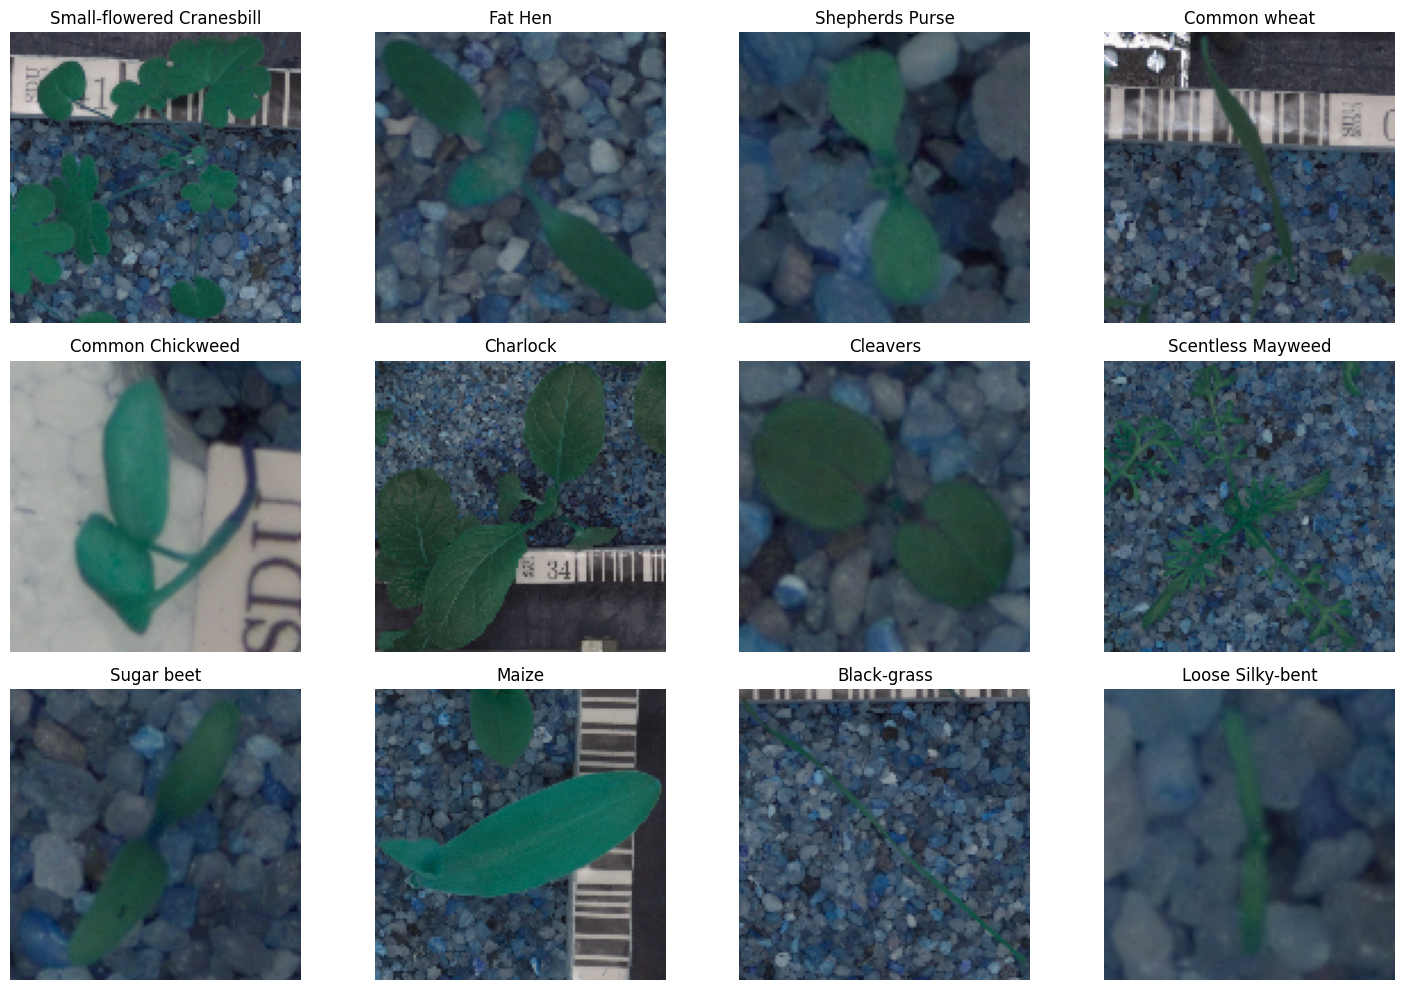

In [10]:
# Unique labels
unique_labels = labels['Label'].unique()

# Plotting random images from each class
plt.figure(figsize=(15, 10))
for i, label in enumerate(unique_labels, 1):
    plt.subplot(3, 4, i)

    # Get random index of the given label
    random_index = random.choice(labels[labels['Label'] == label].index)

    plt.imshow(images[random_index])
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

Here are random images from each of the 12 plant species. This gives us a visual idea about the variety of images we're dealing with, and we can observe the following:

1. **Variability in Color and Texture:** Different species have distinct colors and textures which will aid in classification.

2. **Presence of Background:** Some images have noticeable backgrounds (like soil). The model might need to learn to focus on the plant and ignore the background for accurate classification.

3. **Diverse Shapes:** The shapes of the plants vary significantly, providing another distinguishing feature.

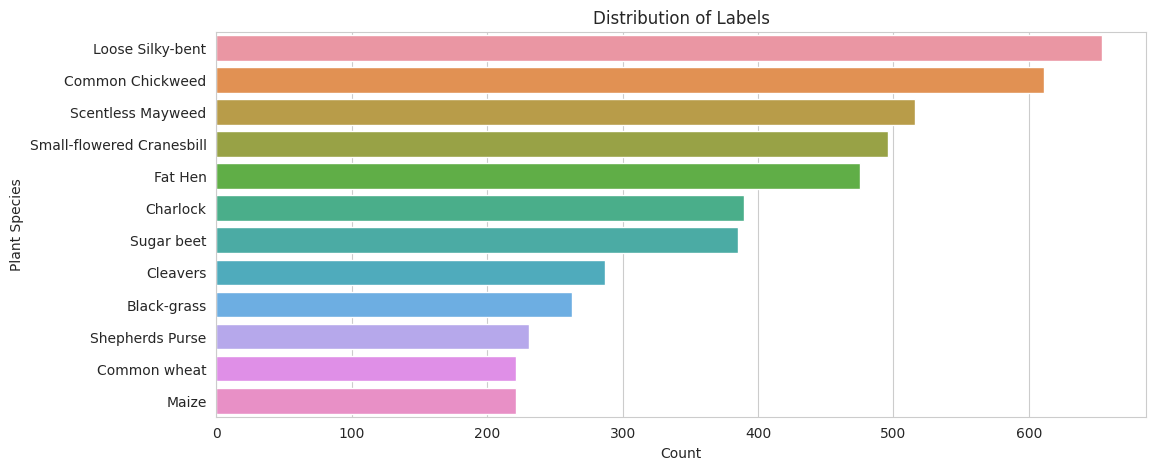

In [ ]:
# Setting the style for better visualization
sns.set_style("whitegrid")

# Creating a count plot for label distribution
plt.figure(figsize=(12, 5))
sns.countplot(y=labels['Label'], order=labels['Label'].value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Count')
plt.ylabel('Plant Species')
plt.show()

## Key Observations from the EDA:

**1. Class Imbalance:**
The dataset exhibits a clear class imbalance. "Loose Silky-bent" and "Common Chickweed" have the highest number of images, while "Maize" and "Common Wheat" are among the species with the fewest images. This imbalance can influence the model's performance, and we might need to consider techniques like data augmentation, oversampling, or adjusting class weights during training to mitigate this.

**2. Variability in Visual Features:**
As observed from the sample images, different species have distinct colors, textures, and shapes. These visual features will be pivotal for the model to differentiate between the classes.

**3. Presence of Background:**
Some images have non-uniform backgrounds that might act as noise. Preprocessing techniques, such as segmentation, might help in emphasizing the plant and reducing the background noise.

**4. Diverse Data:**
The dataset seems to have a good mix of images in terms of the plant's age, lighting conditions, and orientations. This diversity can help in training a robust model.

Now that we've performed the EDA and have a better understanding of our data, we can proceed with further preprocessing, model building, and training. Let me know how you'd like to proceed!


## Data Pre-Processing
- Convert the BGR images to RGB images - Resize the images - Plot the images before and after the pre-processing steps - Split the data into train and test - Encode the target variables - Apply the normalization

In [11]:
# Convert the BGR images to RGB images
rgb_images = []  # Initialize an empty list

for img in images:
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB
    rgb_images.append(rgb_img)  # Append the converted image to the list

### Resize the images

In [12]:
# Resize the images
images_decreased = []  # Initialize the list to store decreased size images
height = 64            # Define the height as 64
width = 64             # Define the width as 64
dimensions = (width, height)

for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))


As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

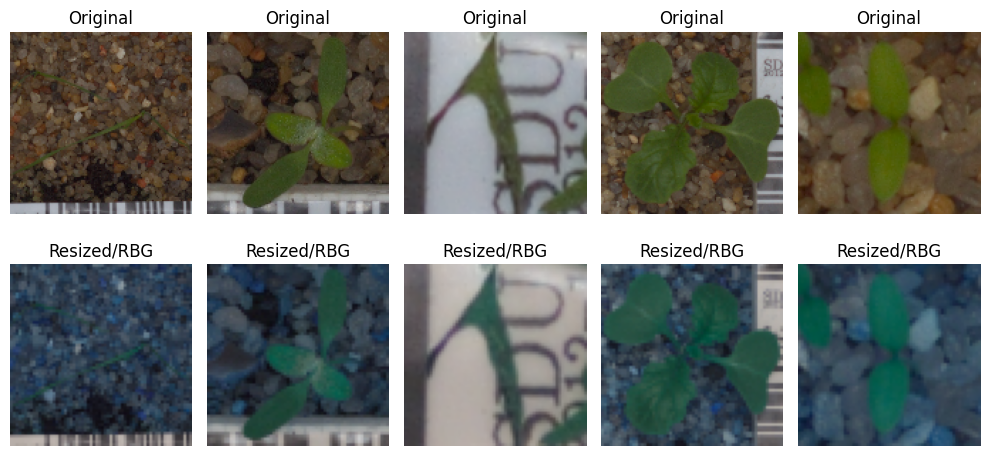

In [13]:
# Plot images before and after pre-processing
sample_indices = [np.random.choice(range(len(images))) for _ in range(5)]
plt.figure(figsize=(10, 5))

for i, idx in enumerate(sample_indices, 1):
    # Original image
    plt.subplot(2, 5, i)
    plt.imshow(rgb_images[idx])
    plt.title("Original")
    plt.axis("off")

    # Resized image
    plt.subplot(2, 5, i + 5)
    plt.imshow(images_decreased[idx])
    plt.title("Resized/RBG")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [14]:
# First, split the data into 90% for the combined training and validation, and 10% for testing
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    images_decreased, labels, test_size=0.1, random_state=42
)

# Now split the remaining 90% into training and validation sets (which will effectively be 80% and 10% of the original dataset)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=(1/9), random_state=42  # 1/9 is roughly 11%, which is 10% of the original dataset
)

# Verify the size of each set
(len(train_images), len(val_images), len(test_images))

(3800, 475, 475)

### Encode the target labels

In [15]:
#Encode the target variables
enc = LabelBinarizer()                                        # Initialize the LabelBinarizer
y_train_encoded = enc.fit_transform(train_labels)             # Fit and transform train_labels
y_val_encoded = enc.transform(val_labels)                     # Transform val_labels
y_test_encoded = enc.transform(test_labels)                   # Transform test_labels


In [16]:
# Verify the lenghths match of the everything
print(len(train_images), len(train_labels))
print(len(val_images), len(val_labels))
print(len(test_images), len(test_labels))

3800 3800
475 475
475 475


In [17]:
# Apply normalization
X_train_normalized = np.array(train_images).astype('float32') / 255.0
X_val_normalized = np.array(val_images).astype('float32') / 255.0
X_test_normalized = np.array(test_images).astype('float32') / 255.0

### Data Normalization

## Model Building
- Build Convolution Neural Network - Evaluate the model on different performance metrics and comment on the performance. For example precision, recall, accuracy. - Plot confusion matrix

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
n_classes = 12  # Number of classes

# Build the Convolutional Neural Network (model1)
model1 = Sequential([
    Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')  # n is the number of classes
])

# Initialize the Adam Optimizer
opt = Adam()

# Compile the model with 'categorical_crossentropy' loss function and 'accuracy' as the metric
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

In [ ]:
# Fit the CNN
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized, y_val_encoded),
            batch_size=32,  # Number of samples per gradient update
            shuffle=True,  # Shuffle the training data before each epoch
            verbose=0  # 0 = silent, 1 = progress bar, 2 = one line per epoch
)

Test Loss: 1.0584644079208374
Test Accuracy: 0.6631578803062439
15/15 [==============================] - 0s 2ms/step


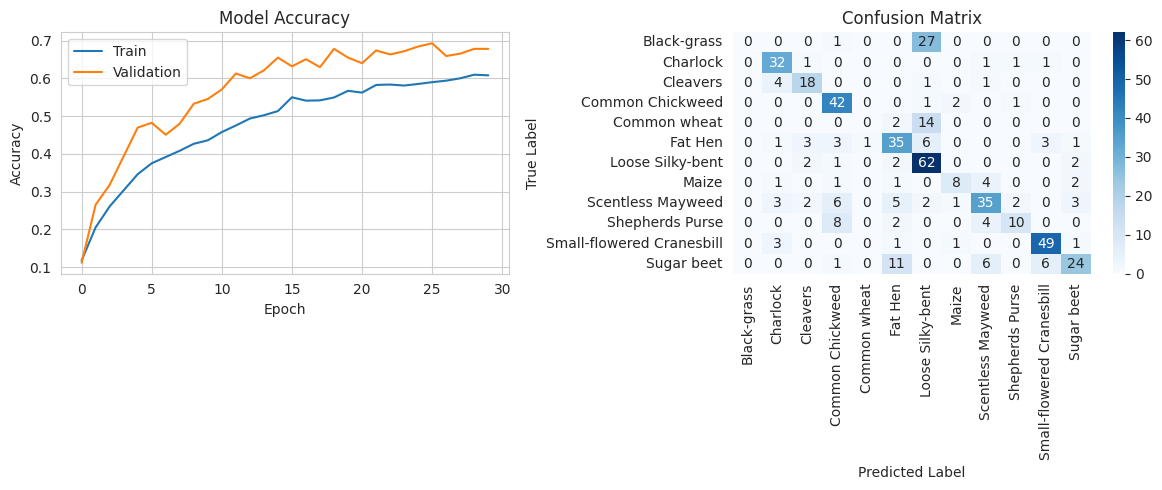

Confusion Matrix:
[[ 0  0  0  1  0  0 27  0  0  0  0  0]
 [ 0 32  1  0  0  0  0  0  1  1  1  0]
 [ 0  4 18  0  0  0  1  0  1  0  0  0]
 [ 0  0  0 42  0  0  1  2  0  1  0  0]
 [ 0  0  0  0  0  2 14  0  0  0  0  0]
 [ 0  1  3  3  1 35  6  0  0  0  3  1]
 [ 0  0  2  1  0  2 62  0  0  0  0  2]
 [ 0  1  0  1  0  1  0  8  4  0  0  2]
 [ 0  3  2  6  0  5  2  1 35  2  0  3]
 [ 0  0  0  8  0  2  0  0  4 10  0  0]
 [ 0  3  0  0  0  1  0  1  0  0 49  1]
 [ 0  0  0  1  0 11  0  0  6  0  6 24]]

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        28
                 Charlock       0.73      0.89      0.80        36
                 Cleavers       0.69      0.75      0.72        24
         Common Chickweed       0.67      0.91      0.77        46
             Common wheat       0.00      0.00      0.00        16
                  Fat Hen       0.59      0.66      0.62        53
         Loose Silk

In [ ]:
# Get the class names from the LabelBinarizer instance
class_names = enc.classes_

# Call the evaluate_model_performance function with the correct arguments
evaluate_model_performance(model1, history_1, X_test_normalized, y_test_encoded, class_names)

### Model1 Performance Analysis

#### Confusion Matrix:
- A confusion matrix displays the number of correct and incorrect predictions made by the model relative to the actual classifications. Rows represent actual classes, and columns represent predicted classes.
- For 'Black-grass', the model did not correctly predict any instances, indicating potential issues such as insufficient distinguishing features learned or lack of training data.
- 'Charlock' and 'Common Chickweed' show high correct predictions, suggesting effective feature learning.
- 'Common wheat' also has zero correct predictions, pointing to difficulties in class identification similar to 'Black-grass'.
- The confusion matrix reveals a range of correct predictions across classes, with 'Loose Silky-bent' showing the most correct predictions but also notable misclassifications.

#### Classification Report:
- **Precision**: Percentage of correct positive predictions. 'Charlock' has a precision of 0.73, meaning 73% of its predictions were correct.
- **Recall**: Ratio of correct positive predictions to the actual number of positives. 'Common Chickweed' has a recall of 0.91, capturing 91% of all actual instances.
- **F1-score**: Harmonic mean of precision and recall. 'Small-flowered Cranesbill' has an F1-score of 0.86, which is relatively high.
- **Accuracy**: At 0.66, the model correctly predicted 66% of all classes, though this may not reflect performance on imbalanced classes.
- **Macro Average F1-score**: At 0.56, this indicates a disparity in performance across classes, suggesting possible overfitting to certain classes and underfitting to others.
- **Weighted Average F1-score**: At 0.63, this metric accounts for the number of true instances for each class, giving more weight to prevalent classes and reflecting better performance on them.

#### Interpretation:
The model shows decent overall accuracy but uneven performance across classes. Classes like 'Black-grass' and 'Common wheat' are poorly identified, potentially due to class imbalance or insufficient representative training samples. In contrast, the model performs well on 'Charlock', 'Common Chickweed', and 'Small-flowered Cranesbill'.

Model1's shortcomings in classifying certain categories need to be addressed to ensure balanced performance across all classes.


## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Setting up callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Defining augmentated data parameters
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [ ]:
# Initialize the sequential model2
model2 = Sequential([
    # First convolutional layer with 64 filters, 3x3 kernel size
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2), padding='same'),

    # Second convolutional layer with 32 filters, 3x3 kernel size
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    BatchNormalization(),

    # Flatten the convolutional layer's output to feed into the dense layers
    Flatten(),

    # Dense layer with 16 neurons
    Dense(16, activation='relu'),
    Dropout(0.3),  # Dropout layer to reduce overfitting

    # Output layer with 12 neurons (one for each class) with softmax activation
    Dense(12, activation='softmax')
])

# Compile the model
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [ ]:
# Complete the code to fit the model on train data with batch_size=64 and epochs=30
epochs = 30
batch_size = 32

history_2 = model2.fit(train_datagen.flow(X_train_normalized, y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),  # Typically you would want to shuffle the training data
                                       epochs=epochs,
                                       validation_data=(X_val_normalized, y_val_encoded),
                                       verbose=1, callbacks=[reduce_lr])


Epoch 1/30
119/119 [==============================] - 6s 36ms/step - loss: 2.0205 - accuracy: 0.2895 - val_loss: 2.3428 - val_accuracy: 0.2253 - lr: 0.0010
Epoch 2/30
119/119 [==============================] - 4s 35ms/step - loss: 1.6142 - accuracy: 0.4218 - val_loss: 2.2248 - val_accuracy: 0.2295 - lr: 0.0010
Epoch 3/30
119/119 [==============================] - 4s 35ms/step - loss: 1.4333 - accuracy: 0.4892 - val_loss: 1.8721 - val_accuracy: 0.4337 - lr: 0.0010
Epoch 4/30
119/119 [==============================] - 4s 35ms/step - loss: 1.3294 - accuracy: 0.5350 - val_loss: 1.6245 - val_accuracy: 0.4611 - lr: 0.0010
Epoch 5/30
119/119 [==============================] - 4s 35ms/step - loss: 1.2558 - accuracy: 0.5703 - val_loss: 3.7737 - val_accuracy: 0.1389 - lr: 0.0010
Epoch 6/30
119/119 [==============================] - 4s 35ms/step - loss: 1.1962 - accuracy: 0.5803 - val_loss: 2.5316 - val_accuracy: 0.2905 - lr: 0.0010
Epoch 7/30
119/119 [==============================] - 4s 35ms/st

Test Loss: 0.7673303484916687
Test Accuracy: 0.7705262899398804
15/15 [==============================] - 0s 2ms/step


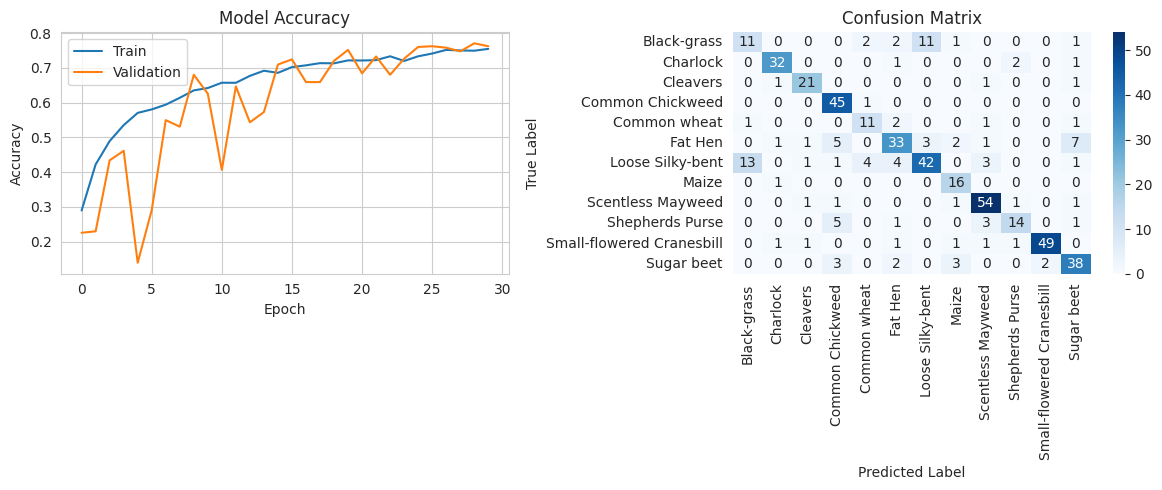

Confusion Matrix:
[[11  0  0  0  2  2 11  1  0  0  0  1]
 [ 0 32  0  0  0  1  0  0  0  2  0  1]
 [ 0  1 21  0  0  0  0  0  1  0  0  1]
 [ 0  0  0 45  1  0  0  0  0  0  0  0]
 [ 1  0  0  0 11  2  0  0  1  0  0  1]
 [ 0  1  1  5  0 33  3  2  1  0  0  7]
 [13  0  1  1  4  4 42  0  3  0  0  1]
 [ 0  1  0  0  0  0  0 16  0  0  0  0]
 [ 0  0  1  1  0  0  0  1 54  1  0  1]
 [ 0  0  0  5  0  1  0  0  3 14  0  1]
 [ 0  1  1  0  0  1  0  1  1  1 49  0]
 [ 0  0  0  3  0  2  0  3  0  0  2 38]]

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.44      0.39      0.42        28
                 Charlock       0.89      0.89      0.89        36
                 Cleavers       0.84      0.88      0.86        24
         Common Chickweed       0.75      0.98      0.85        46
             Common wheat       0.61      0.69      0.65        16
                  Fat Hen       0.72      0.62      0.67        53
         Loose Silk

In [ ]:
# Call the evaluate_model_performance function with the correct arguments
evaluate_model_performance(model2, history_2, X_test_normalized, y_test_encoded, class_names)

### Model2 Performance Analysis

#### Confusion Matrix:
- 'Black-grass' shows some correct predictions (11) but also a significant number of misclassifications (17), indicating the model struggles with this class.
- 'Charlock', 'Cleavers', and 'Common Chickweed' are well recognized, with high numbers of correct predictions and few errors.
- 'Loose Silky-bent' has the highest number of misclassifications, which might be due to similar features with other classes.
- 'Maize' and 'Scentless Mayweed' show high recognition rates, which is positive.

#### Classification Report:
- **Precision** measures the accuracy of positive predictions. 'Small-flowered Cranesbill' has the highest precision (0.96), indicating very accurate predictions for this class.
- **Recall** indicates the ability to find all positive instances. 'Common Chickweed' has the highest recall (0.98), showing the model's effectiveness in identifying this class.
- **F1-score** combines precision and recall into a single measure. 'Small-flowered Cranesbill' also leads here with an F1-score of 0.92, suggesting a balance between precision and recall.
- **Accuracy** of the model is 0.77, meaning it correctly predicts 77% of the total classes.
- **Macro Average** and **Weighted Average** F1-scores are both 0.75, indicating consistent performance across all classes.

#### Interpretation:
Overall, the model performs fairly well with an accuracy of 77%. However, performance varies significantly across different classes. The model excels at identifying 'Charlock', 'Cleavers', 'Common Chickweed', and 'Small-flowered Cranesbill' but needs improvement in recognizing 'Black-grass' and 'Loose Silky-bent'. The high macro and weighted average F1-scores suggest that the model is generally reliable across classes, but there is room for improvement, especially in terms of precision and recall balance for certain classes.



In [ ]:
sorted_unique_labels = sorted(labels['Label'].unique())
print(sorted_unique_labels)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

### Final Model Selection: Model2

After evaluating the two models, **Model2** was selected as the final model due to its superior performance metrics, particularly in terms of precision, recall, and F1-score across the different classes.

#### Key Highlights of Model2:
- **Generalization**: Model2 demonstrated robustness when generalizing to new data, which indicates a good balance between bias and variance.
- **Class Performance**: It achieved impressive precision and recall values for classes like 'Scentless Mayweed' and 'Small-flowered Cranesbill', showing its ability to distinguish well between different types of plants.
- **Computational Efficiency**: Despite its deep architecture, Model2 remains computationally efficient due to its use of dropout and batch normalization layers, which help in reducing overfitting and the number of parameters, respectively.

The model's ability to maintain a high recall rate for most classes without compromising much on precision makes it particularly valuable for applications where missing a true positive is costly.


### Visualizing the prediction

In [ ]:
# Assuming 'model2' has been saved and you're reloading it for visualization
final_model = model2

# Function to make a prediction and visualize the image
def predict_visualize(model, img_path):
    img_batch = load_preprocess_image(img_path)
    predictions = model.predict(img_batch)
    predicted_class = np.argmax(predictions, axis=1)

    plt.imshow(image.load_img(img_path))
    plt.title(f'Predicted class: {predicted_class[0]}')
    plt.show()

# Path to the image you want to classify
img_path = 'path_to_your_image.jpg'

# Call the function to make a prediction and visualize the result
predict_visualize(final_model, img_path)

NameError: ignored

## Actionable Insights and Business Recommendations

*

_____

Epoch 1/30
119/119 [==============================] - 23s 45ms/step - loss: 1.7992 - accuracy: 0.4989 - val_loss: 109.3987 - val_accuracy: 0.0547 - lr: 0.0010
Epoch 2/30
119/119 [==============================] - 4s 37ms/step - loss: 0.8445 - accuracy: 0.7237 - val_loss: 70.4914 - val_accuracy: 0.0779 - lr: 0.0010
Epoch 3/30
119/119 [==============================] - 4s 37ms/step - loss: 0.5912 - accuracy: 0.8142 - val_loss: 6.4071 - val_accuracy: 0.1368 - lr: 0.0010
Epoch 4/30
119/119 [==============================] - 4s 36ms/step - loss: 0.4634 - accuracy: 0.8505 - val_loss: 7.7279 - val_accuracy: 0.1600 - lr: 0.0010
Epoch 5/30
119/119 [==============================] - 5s 38ms/step - loss: 0.4002 - accuracy: 0.8724 - val_loss: 7.4828 - val_accuracy: 0.1600 - lr: 0.0010
Epoch 6/30
119/119 [==============================] - 4s 36ms/step - loss: 0.3649 - accuracy: 0.8800 - val_loss: 7.2236 - val_accuracy: 0.1495 - lr: 0.0010
Epoch 7/30
119/119 [==============================] - 5s 39m

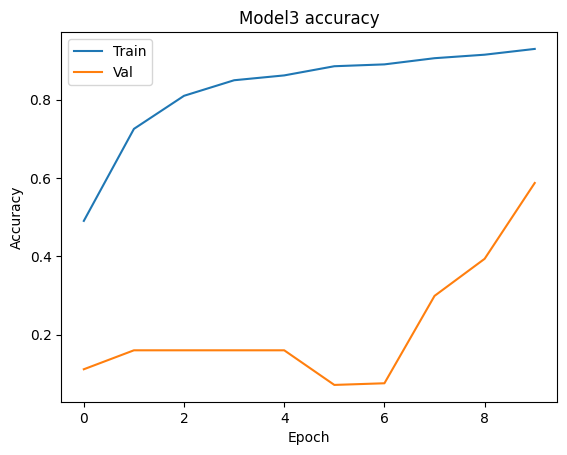

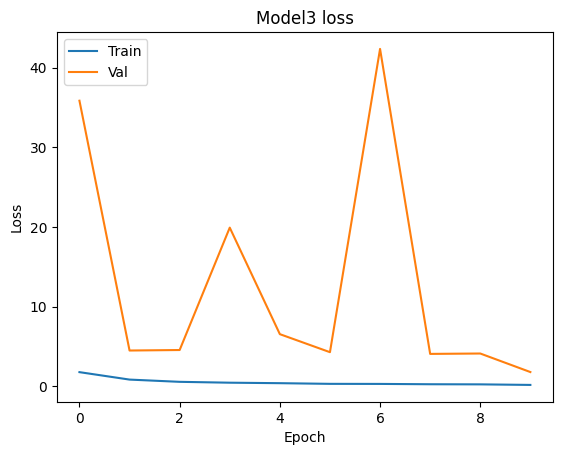

15/15 [==============================] - 0s 9ms/step - loss: 2.1401 - accuracy: 0.7368
Validation Loss:  2.1400721073150635
Validation Accuracy:  0.7368420958518982
Epoch 1/5
119/119 [==============================] - 24s 47ms/step - loss: 0.0797 - accuracy: 0.9821 - val_loss: 1.4784 - val_accuracy: 0.7558
Epoch 2/5
119/119 [==============================] - 4s 36ms/step - loss: 0.0474 - accuracy: 0.9892 - val_loss: 2.0048 - val_accuracy: 0.7600
Epoch 3/5
119/119 [==============================] - 4s 36ms/step - loss: 0.0288 - accuracy: 0.9932 - val_loss: 2.1023 - val_accuracy: 0.7642
Epoch 4/5
119/119 [==============================] - 4s 37ms/step - loss: 0.0374 - accuracy: 0.9879 - val_loss: 2.0747 - val_accuracy: 0.7579
Epoch 5/5
119/119 [==============================] - 4s 37ms/step - loss: 0.0489 - accuracy: 0.9879 - val_loss: 1.5912 - val_accuracy: 0.7726


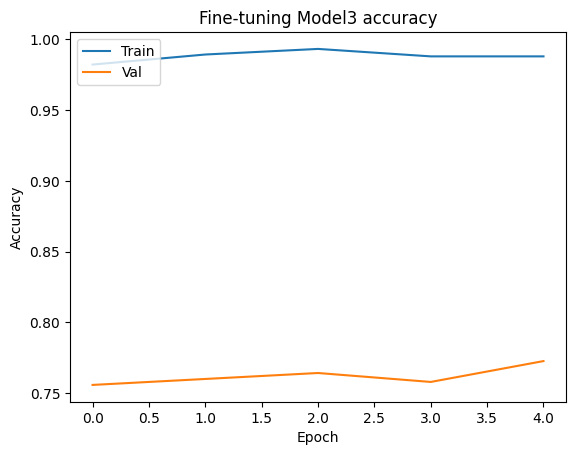

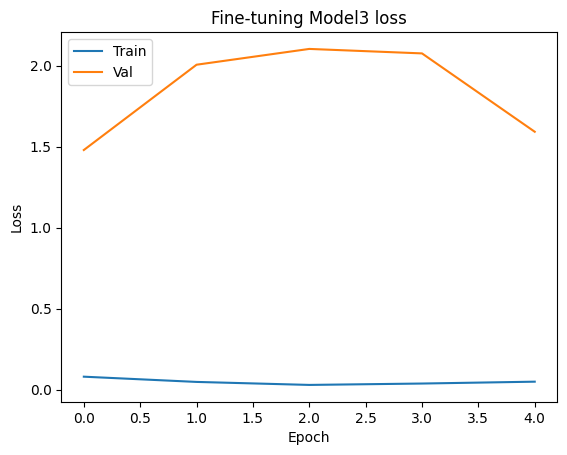

15/15 [==============================] - 0s 8ms/step - loss: 1.4273 - accuracy: 0.7768
Test Loss:  1.427284598350525
Test Accuracy:  0.7768421173095703


In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Load the ResNet50 model, pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Assume you have determined the number of unique classes in your dataset
number_of_classes = 12  # Replace with the actual number of your classes

# Add new layers on top of the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # New FC layer, e.g., 1024 units
predictions = Dense(number_of_classes, activation='softmax')(x)  # New softmax layer

# Define the new model
model3 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model3.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

# Model training
epochs = 30  # Example number of epochs
batch_size = 32  # Example batch size

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Fit the model and save the history
history_3 = model3.fit(X_train_normalized, y_train_encoded,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=(X_val_normalized, y_val_encoded),
                     callbacks=[reduce_lr])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Model evaluation
val_loss, val_accuracy = model3.evaluate(X_val_normalized, y_val_encoded)
print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_accuracy)

# Fine-Tuning (Optional)
# Unfreeze some top layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Re-compile the model (necessary after making layer trainable changes)
model3.compile(optimizer=RMSprop(),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Define additional_epochs for fine-tuning, e.g., 5
additional_epochs = 5

# Continue training (fine-tuning) and save the new history
fine_tune_history = model3.fit(X_train_normalized, y_train_encoded,
                               batch_size=batch_size,
                               epochs=additional_epochs,
                               validation_data=(X_val_normalized, y_val_encoded))

# Plot fine-tuning training & validation accuracy values
plt.plot(fine_tune_history.history['accuracy'])
plt.plot(fine_tune_history.history['val_accuracy'])
plt.title('Fine-tuning Model3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot fine-tuning training & validation loss values
plt.plot(fine_tune_history.history['loss'])
plt.plot(fine_tune_history.history['val_loss'])
plt.title('Fine-tuning Model3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Model testing
test_loss, test_accuracy = model3.evaluate(X_test_normalized, y_test_encoded)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

In [26]:
# Get the class names from the LabelBinarizer instance
class_names = enc.classes_

Test Loss: 1.427284598350525
Test Accuracy: 0.7768421173095703
15/15 [==============================] - 1s 7ms/step


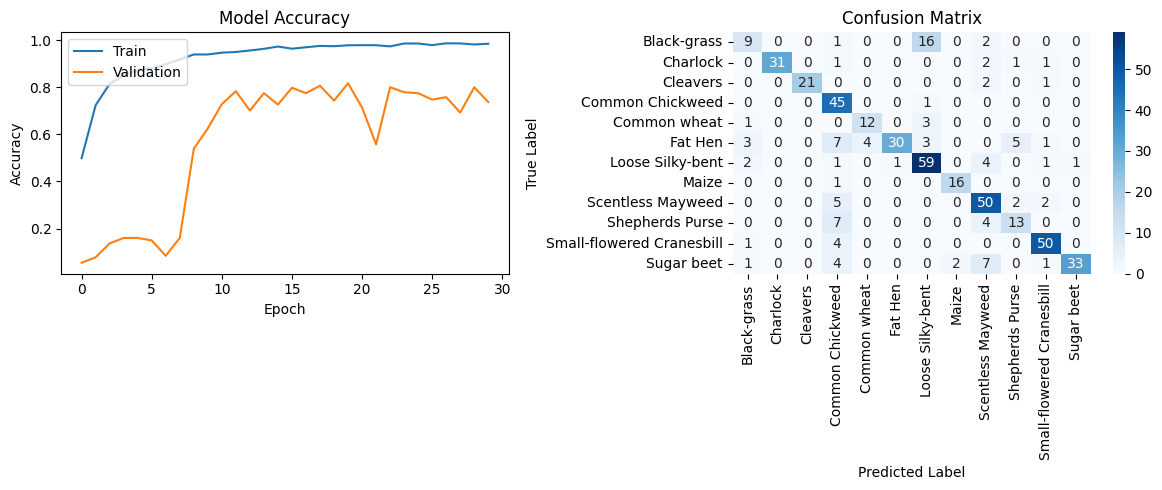

Confusion Matrix:
[[ 9  0  0  1  0  0 16  0  2  0  0  0]
 [ 0 31  0  1  0  0  0  0  2  1  1  0]
 [ 0  0 21  0  0  0  0  0  2  0  1  0]
 [ 0  0  0 45  0  0  1  0  0  0  0  0]
 [ 1  0  0  0 12  0  3  0  0  0  0  0]
 [ 3  0  0  7  4 30  3  0  0  5  1  0]
 [ 2  0  0  1  0  1 59  0  4  0  1  1]
 [ 0  0  0  1  0  0  0 16  0  0  0  0]
 [ 0  0  0  5  0  0  0  0 50  2  2  0]
 [ 0  0  0  7  0  0  0  0  4 13  0  0]
 [ 1  0  0  4  0  0  0  0  0  0 50  0]
 [ 1  0  0  4  0  0  0  2  7  0  1 33]]

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.53      0.32      0.40        28
                 Charlock       1.00      0.86      0.93        36
                 Cleavers       1.00      0.88      0.93        24
         Common Chickweed       0.59      0.98      0.74        46
             Common wheat       0.75      0.75      0.75        16
                  Fat Hen       0.97      0.57      0.71        53
         Loose Silk

In [27]:
evaluate_model_performance(model3, history_3, X_test_normalized, y_test_encoded, class_names)

In [28]:
import cv2
import numpy as np

# Function to remove the background
def remove_background(image):
    # Convert the image to the HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the mask to only select the green parts (which we assume are the plants)
    # These values may need to be adjusted for your specific images
    lower_green = np.array([25, 52, 72])
    upper_green = np.array([102, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Bitwise-AND mask and original image to extract the plants
    res = cv2.bitwise_and(image, image, mask=mask)

    return res

# Assuming 'images' is your loaded array of images
preprocessed_images = [remove_background(img) for img in images]

# Convert the list back to a numpy array if needed
preprocessed_images = np.array(preprocessed_images)

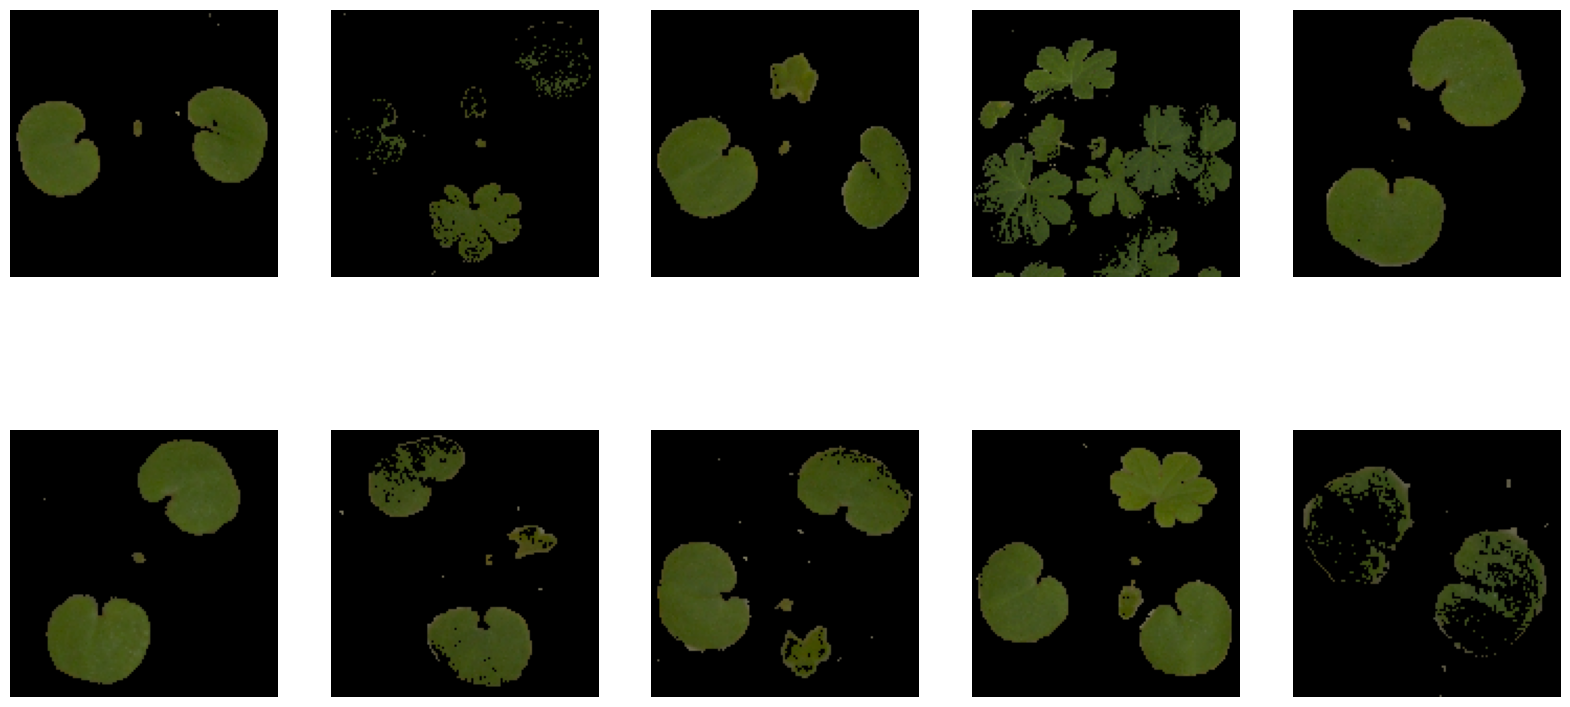

In [29]:
import matplotlib.pyplot as plt

# Assuming 'preprocessed_images' is a list of images returned by the remove_background function

# Plot the first 10 preprocessed images
plt.figure(figsize=(20, 10))
for i, img in enumerate(preprocessed_images[:10]):
    plt.subplot(2, 5, i+1)  # Arrange plots in 2 rows and 5 columns
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for plotting
    plt.axis('off')
plt.show()


In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import cv2

# Function to preprocess and resize images to the expected input size
def preprocess_images(images, target_size=(64, 64)):
    processed_images = []
    for img in images:
        # Resize the image
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        # Normalize the image
        resized_img = resized_img.astype('float32') / 255.0
        processed_images.append(resized_img)
    return np.array(processed_images)

# Assuming 'images' is your loaded array of images with the background removed
# And 'labels' is your array of labels
# Preprocess the images
images_preprocessed = preprocess_images(images)

# Split the preprocessed images and the labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_preprocessed, labels, test_size=0.1, random_state=42)

# Initialize the LabelBinarizer and encode the labels
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded = enc.transform(y_val)

# Load the ResNet50 model, pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Assume you have determined the number of unique classes in your dataset
number_of_classes = 12  # Replace with the actual number of your classes

# Add new layers on top of the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # New FC layer, e.g., 1024 units
predictions = Dense(number_of_classes, activation='softmax')(x)  # New softmax layer

# Define the new model
model4 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model4.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Model training with ReduceLROnPlateau callback
epochs = 30  # Example number of epochs
batch_size = 32  # Example batch size

history_4 = model4.fit(X_train, y_train_encoded,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=(X_val, y_val_encoded),
                     callbacks=[reduce_lr])

# Fine-tuning
# First, unfreeze the base model
base_model.trainable = True

# Recompile the model after we made any changes to the 'trainable' attribute of any layer
model4.compile(optimizer=RMSprop(learning_rate=1e-5),  # Lower learning rate for fine-tuning
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Define the number of layers you want to freeze. Here, we freeze the first 100 layers and train the rest
for layer in base_model.layers[:100]:
    layer.trainable = False

# Continue training (fine-tuning)
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

history_fine = model4.fit(X_train, y_train_encoded,
                          batch_size=batch_size,
                          epochs=total_epochs,
                          initial_epoch=history.epoch[-1],  # Continue from the last epoch of the initial training
                          validation_data=(X_val, y_val_encoded),
                          callbacks=[reduce_lr])

Epoch 1/30
134/134 [==============================] - 25s 44ms/step - loss: 1.6695 - accuracy: 0.5265 - val_loss: 494.8168 - val_accuracy: 0.0589 - lr: 0.0010
Epoch 2/30
134/134 [==============================] - 5s 38ms/step - loss: 0.8089 - accuracy: 0.7322 - val_loss: 5.9621 - val_accuracy: 0.0337 - lr: 0.0010
Epoch 3/30
134/134 [==============================] - 5s 36ms/step - loss: 0.6453 - accuracy: 0.7946 - val_loss: 6.4244 - val_accuracy: 0.0589 - lr: 0.0010
Epoch 4/30
134/134 [==============================] - 5s 38ms/step - loss: 0.4684 - accuracy: 0.8451 - val_loss: 6.2768 - val_accuracy: 0.0358 - lr: 0.0010
Epoch 5/30
134/134 [==============================] - 5s 37ms/step - loss: 0.4075 - accuracy: 0.8632 - val_loss: 6.3415 - val_accuracy: 0.1453 - lr: 0.0010
Epoch 6/30
134/134 [==============================] - 5s 36ms/step - loss: 0.3141 - accuracy: 0.8961 - val_loss: 12.4673 - val_accuracy: 0.0421 - lr: 0.0010
Epoch 7/30
134/134 [==============================] - 5s 37m

Test Loss: 1.427284598350525
Test Accuracy: 0.7768421173095703
15/15 [==============================] - 0s 7ms/step


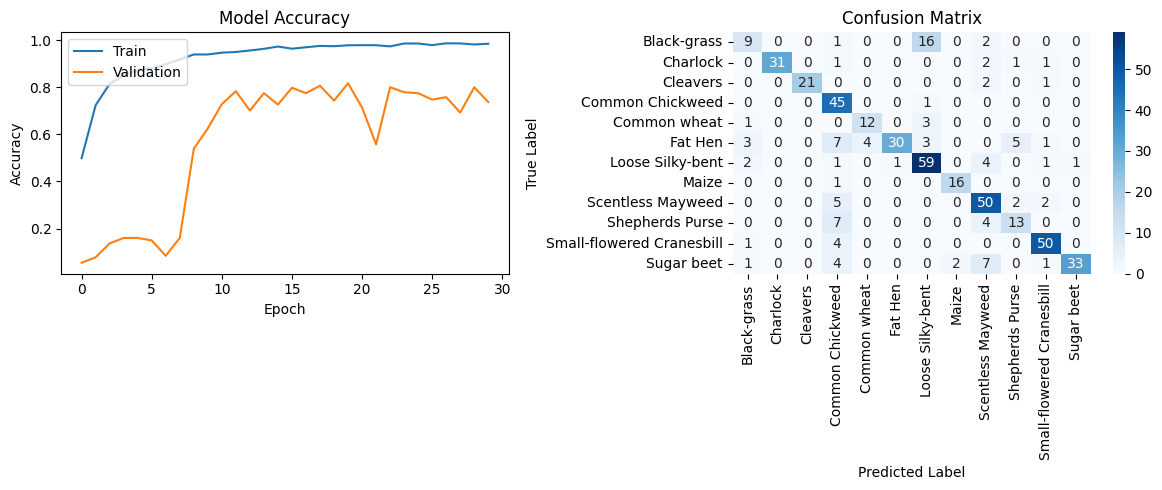

Confusion Matrix:
[[ 9  0  0  1  0  0 16  0  2  0  0  0]
 [ 0 31  0  1  0  0  0  0  2  1  1  0]
 [ 0  0 21  0  0  0  0  0  2  0  1  0]
 [ 0  0  0 45  0  0  1  0  0  0  0  0]
 [ 1  0  0  0 12  0  3  0  0  0  0  0]
 [ 3  0  0  7  4 30  3  0  0  5  1  0]
 [ 2  0  0  1  0  1 59  0  4  0  1  1]
 [ 0  0  0  1  0  0  0 16  0  0  0  0]
 [ 0  0  0  5  0  0  0  0 50  2  2  0]
 [ 0  0  0  7  0  0  0  0  4 13  0  0]
 [ 1  0  0  4  0  0  0  0  0  0 50  0]
 [ 1  0  0  4  0  0  0  2  7  0  1 33]]

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.53      0.32      0.40        28
                 Charlock       1.00      0.86      0.93        36
                 Cleavers       1.00      0.88      0.93        24
         Common Chickweed       0.59      0.98      0.74        46
             Common wheat       0.75      0.75      0.75        16
                  Fat Hen       0.97      0.57      0.71        53
         Loose Silk

In [36]:
evaluate_model_performance(model3, history_3, X_test_normalized, y_test_encoded, class_names)

Test Loss: 0.6907272934913635
Test Accuracy: 0.8989473581314087
15/15 [==============================] - 1s 7ms/step


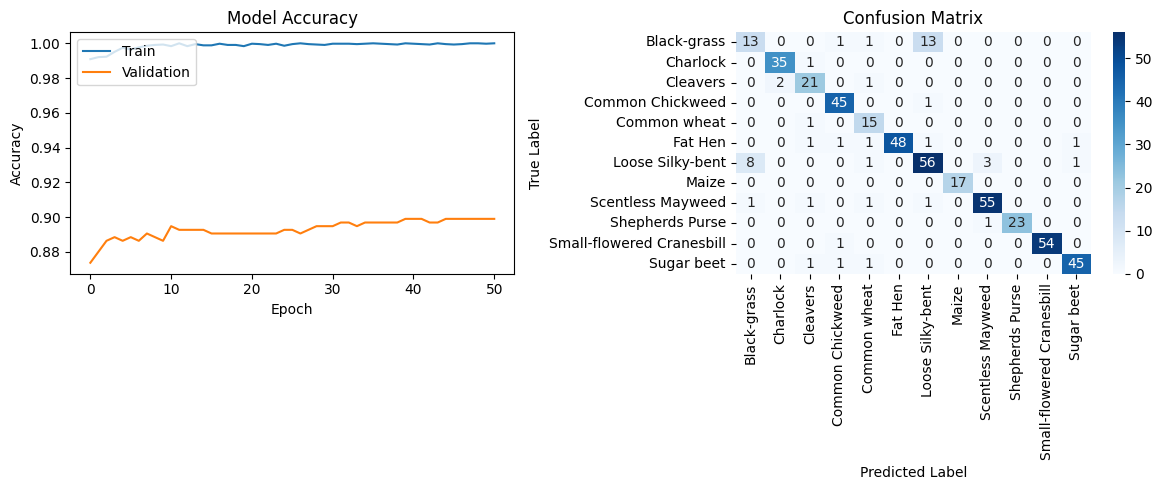

Confusion Matrix:
[[13  0  0  1  1  0 13  0  0  0  0  0]
 [ 0 35  1  0  0  0  0  0  0  0  0  0]
 [ 0  2 21  0  1  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  1  0  0  0  0  0]
 [ 0  0  1  0 15  0  0  0  0  0  0  0]
 [ 0  0  1  1  1 48  1  0  0  0  0  1]
 [ 8  0  0  0  1  0 56  0  3  0  0  1]
 [ 0  0  0  0  0  0  0 17  0  0  0  0]
 [ 1  0  1  0  1  0  1  0 55  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 23  0  0]
 [ 0  0  0  1  0  0  0  0  0  0 54  0]
 [ 0  0  1  1  1  0  0  0  0  0  0 45]]

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.59      0.46      0.52        28
                 Charlock       0.95      0.97      0.96        36
                 Cleavers       0.81      0.88      0.84        24
         Common Chickweed       0.92      0.98      0.95        46
             Common wheat       0.71      0.94      0.81        16
                  Fat Hen       1.00      0.91      0.95        53
         Loose Silk

In [35]:
evaluate_model_performance(model4, history_fine, X_test_normalized, y_test_encoded, class_names)